In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Before we get started, let's take a quick look at datasets.

**The objective of the dataset**

> This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**The Pima Indian Diabetes data set consists of:**

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

--------------------------------------------------------------------------------------------------------------------------
# Load Libraries

In [5]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

In [6]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [7]:
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Pregnancies,6.000000,1.000000,8.000000,1.000000,0.000000
Glucose,148.000000,85.000000,183.000000,89.000000,137.000000
BloodPressure,72.000000,66.000000,64.000000,66.000000,40.000000
SkinThickness,35.000000,29.000000,0.000000,23.000000,35.000000
Insulin,0.000000,0.000000,0.000000,94.000000,168.000000
BMI,33.600000,26.600000,23.300000,28.100000,43.100000
DiabetesPedigreeFunction,0.627000,0.351000,0.672000,0.167000,2.288000
Age,50.000000,31.000000,32.000000,21.000000,33.000000
Outcome,1.000000,0.000000,1.000000,0.000000,1.000000


In [8]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


DiabetesPedigreeFunction has a long name. Change to DPF.

In [9]:
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

<AxesSubplot:>

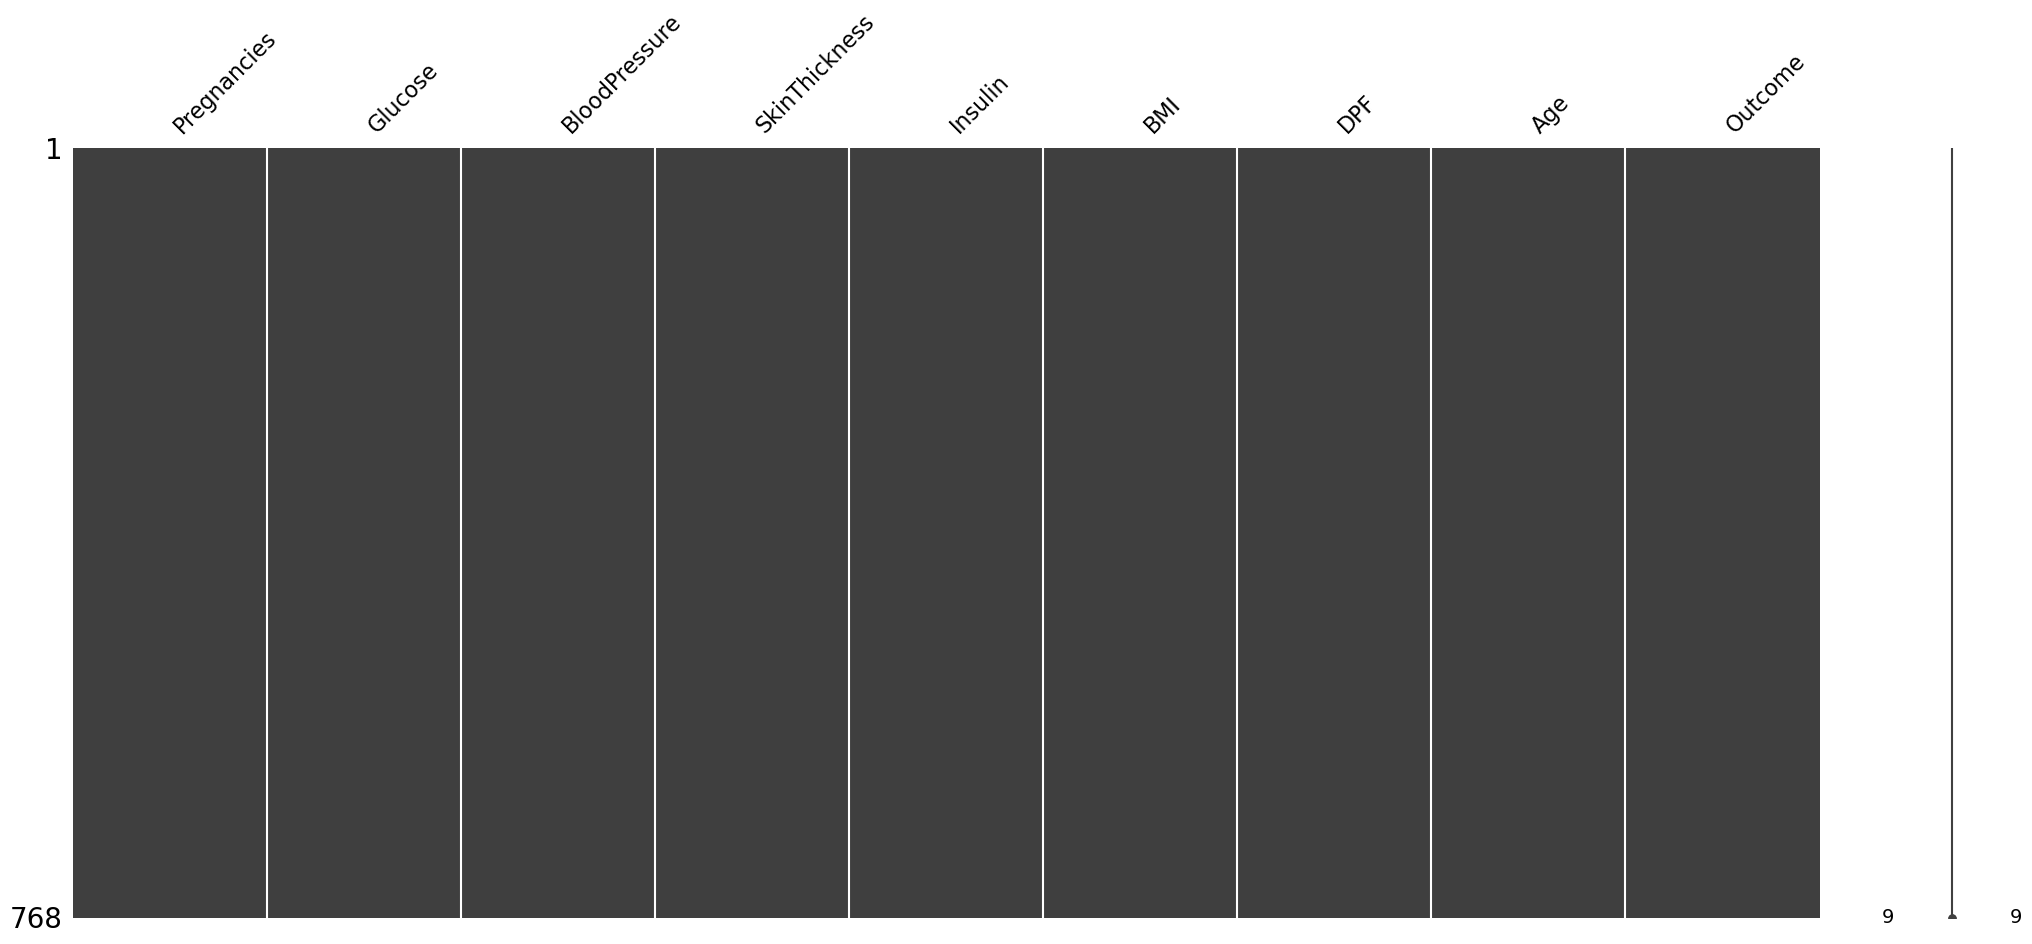

In [10]:
import missingno as msno
msno.matrix(diabetes_df)

In [11]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = diabetes_df['Outcome'].value_counts()/diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

## Checking Statistics

In [12]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')
diabetes_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


--------------------------------------------------
# Checking and Removing Outliers

In [13]:
feature_names = [cname for cname in diabetes_df.loc[:,:'Age'].columns]

In [15]:
rcParams['fig.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

KeyError: 'fig.figsize is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

Looking at the pictures above, it would be good to change the zero value of each feature to another value.
First, let's calculate the proportion of zero values in each feature.

In [16]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


As shown above, the ratio of the value of zero in the SkinThickness and Insulin features seems to be high. Let's change the corresponding values to the mean value of each feature. 

> However, a zero value may be meaningful to the corresponding feature. If you have an expert with expertise in diabetes, you will be able to confirm that your decision is correct.
However, since there is no such domain knowledge or friends, we will first replace the corresponding value with the mean value.

In [17]:
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

If we remove the zero value of each feature, we have a distribution similar to the normal distribution. Therefore, perform linear scaling and standard scaling.

In [18]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

-------------------------------------------
# Scaling



In [19]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

X_train.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,4.315407,121.709154,72.144653,26.341978,118.600098,32.315027,0.468618,32.921875
std,2.916151,30.080570,12.113756,9.158041,94.570101,6.878494,0.339325,11.507539
min,1.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,100.000000,64.000000,20.536458,79.799479,27.275000,0.240000,24.000000
50%,3.845052,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,138.250000,80.000000,32.000000,127.500000,36.325000,0.612250,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


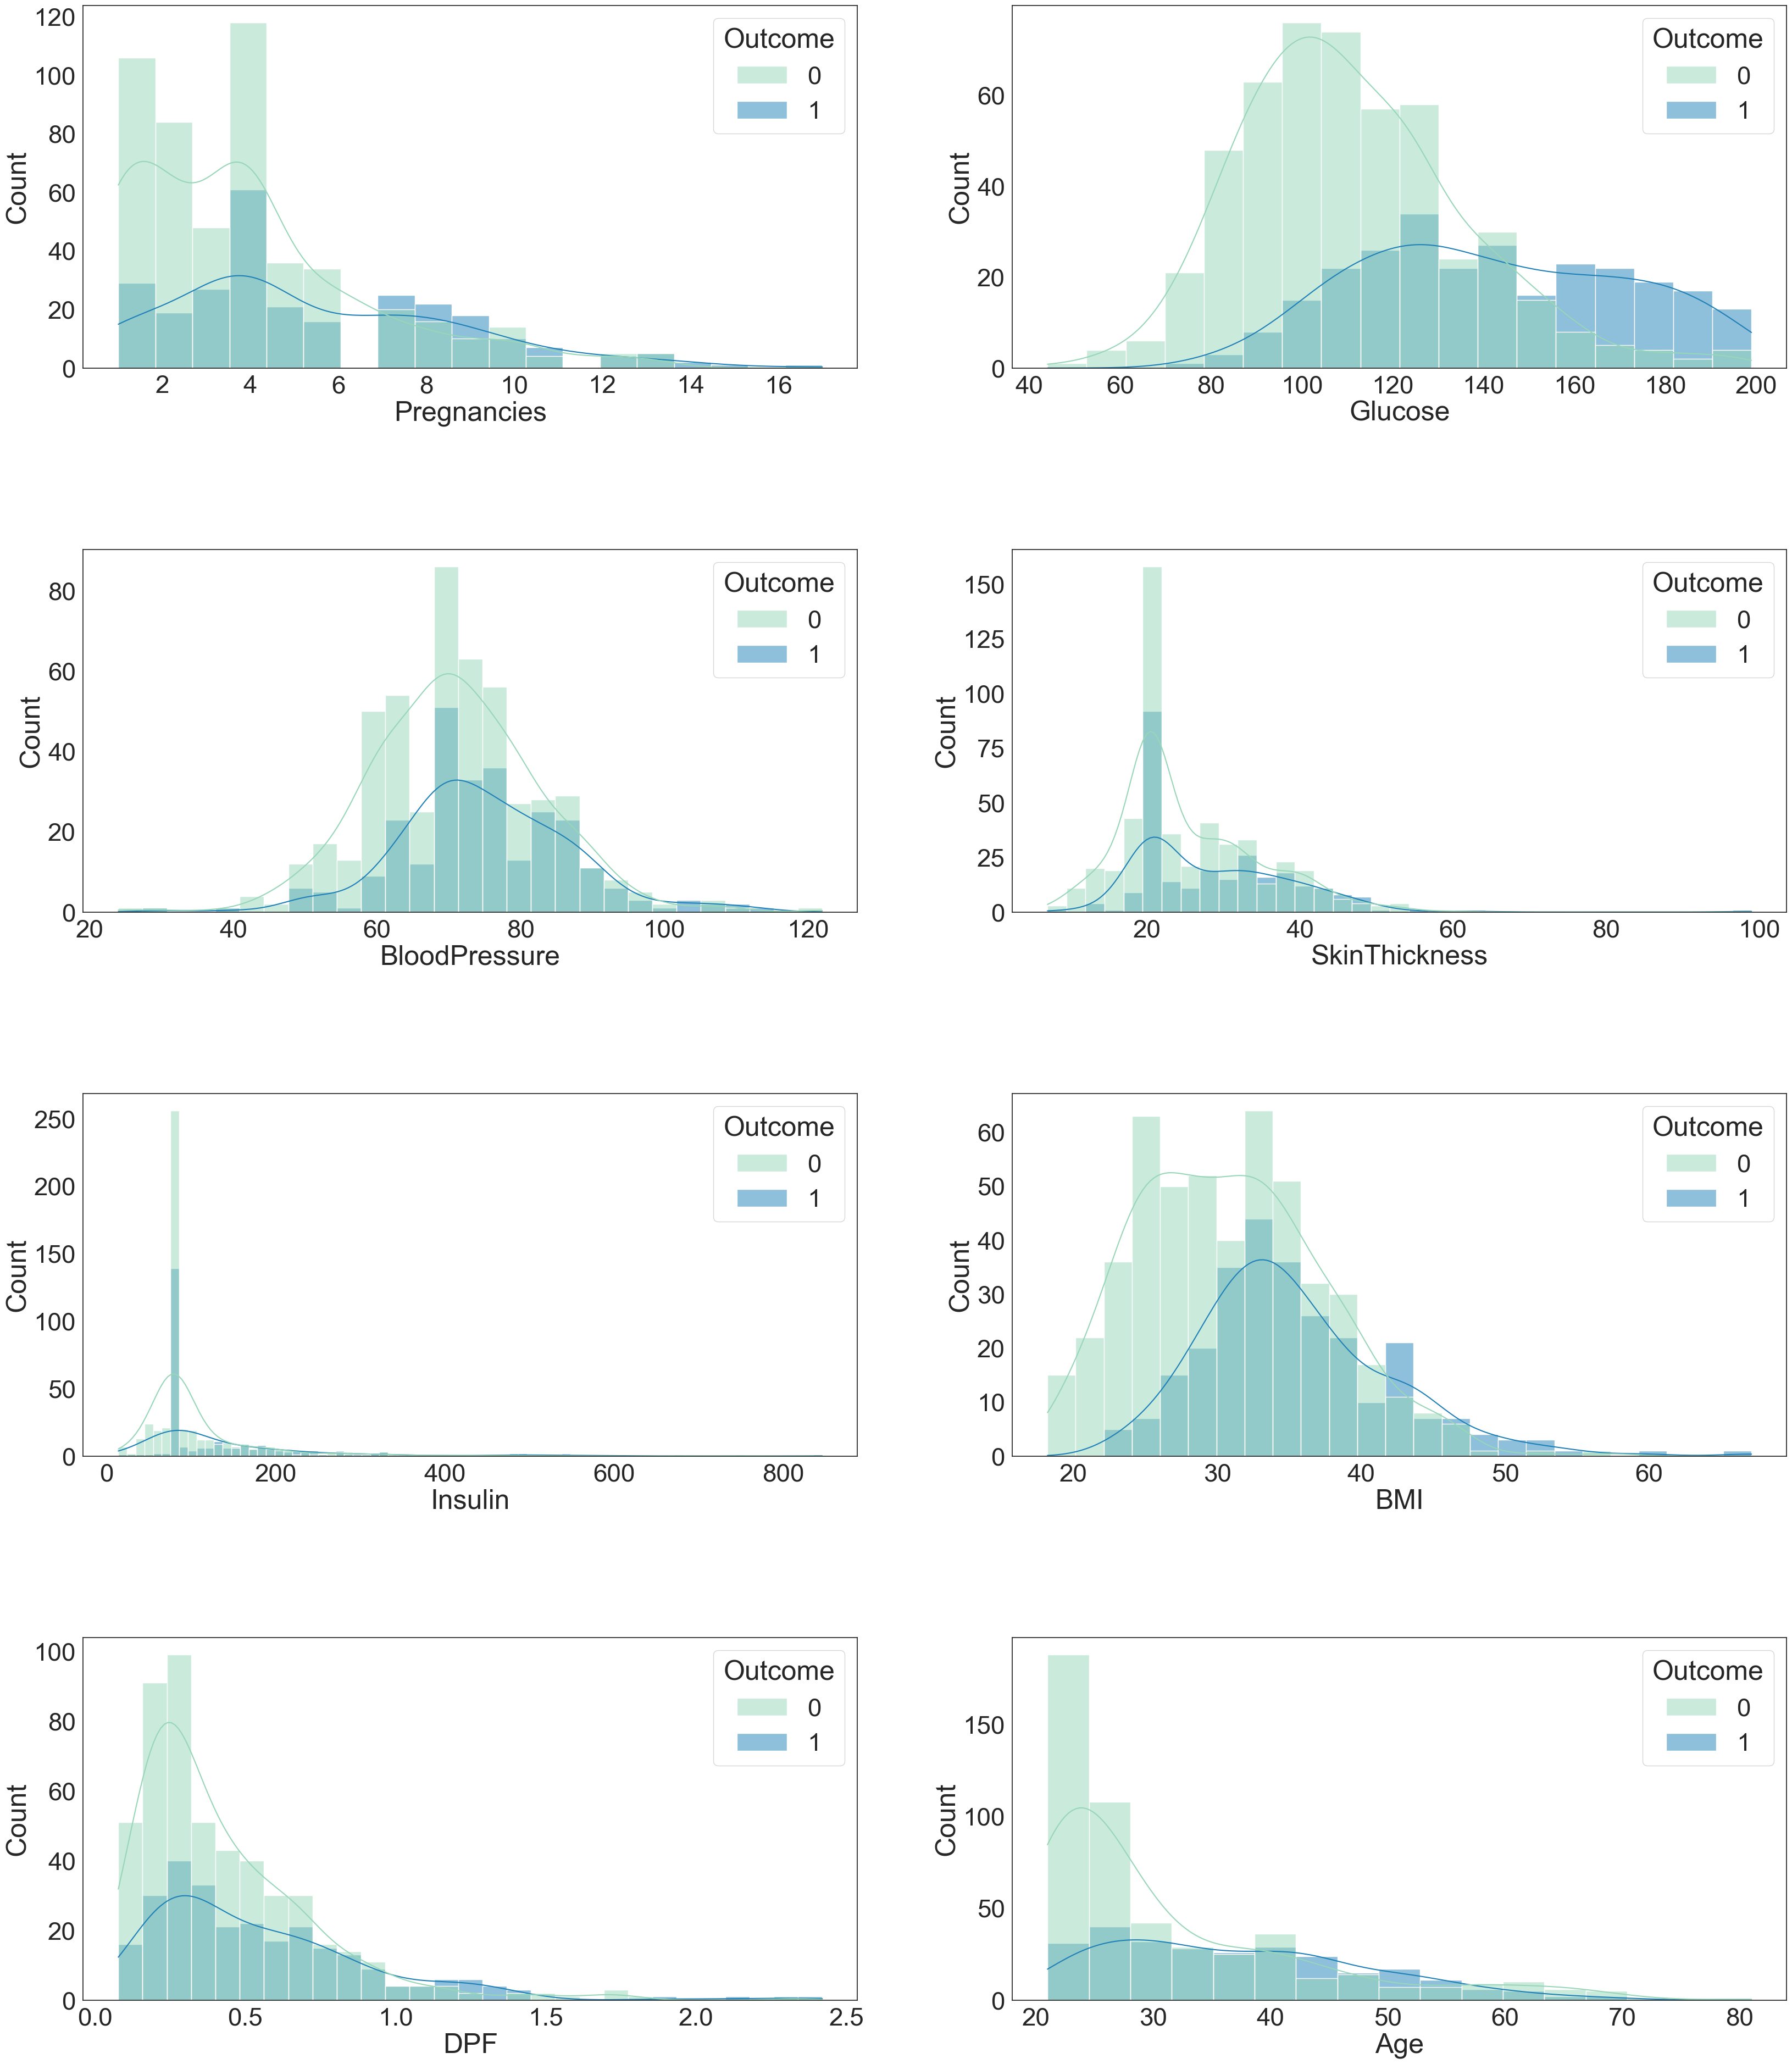

In [22]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

# Checking correlation between features



Text(0.5, 1.0, 'Correlation Plot')

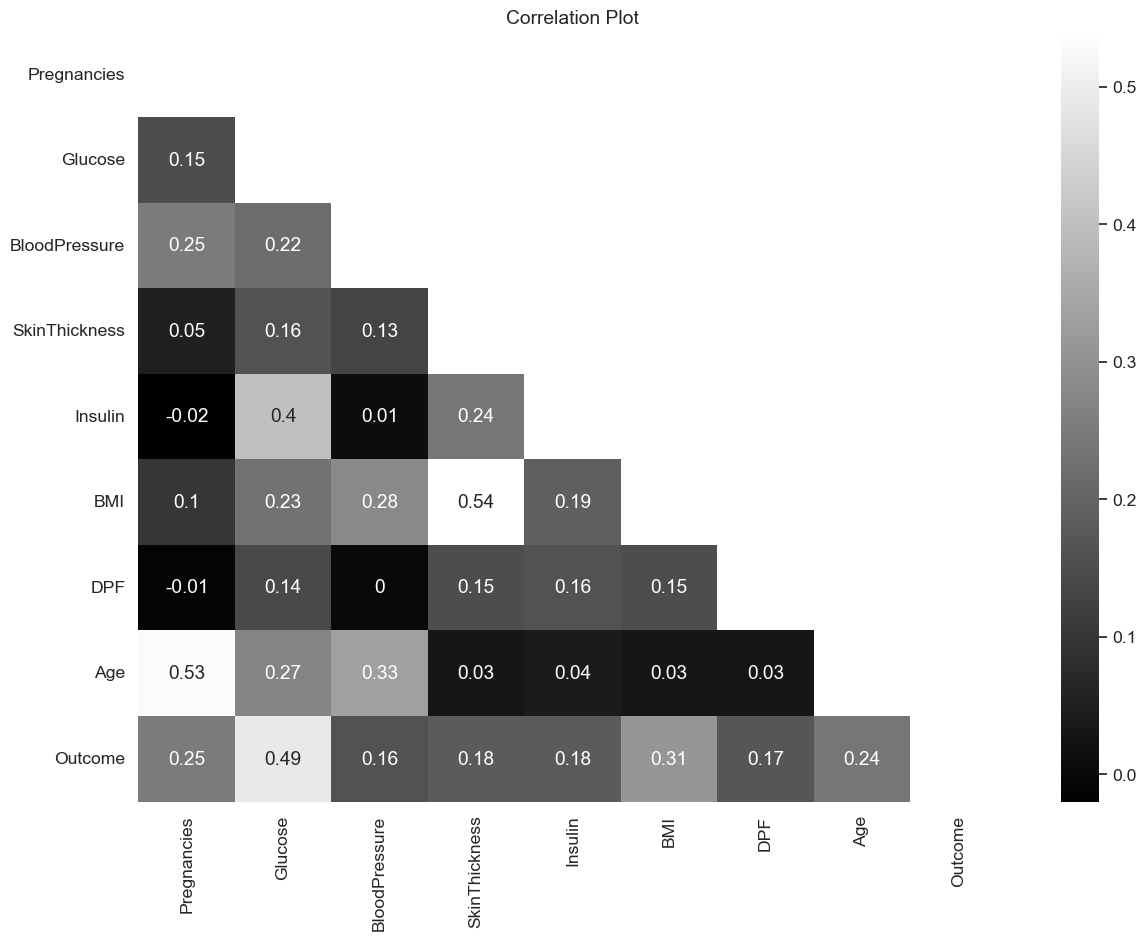

In [23]:
corr=diabetes_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

<Figure size 1000x800 with 0 Axes>

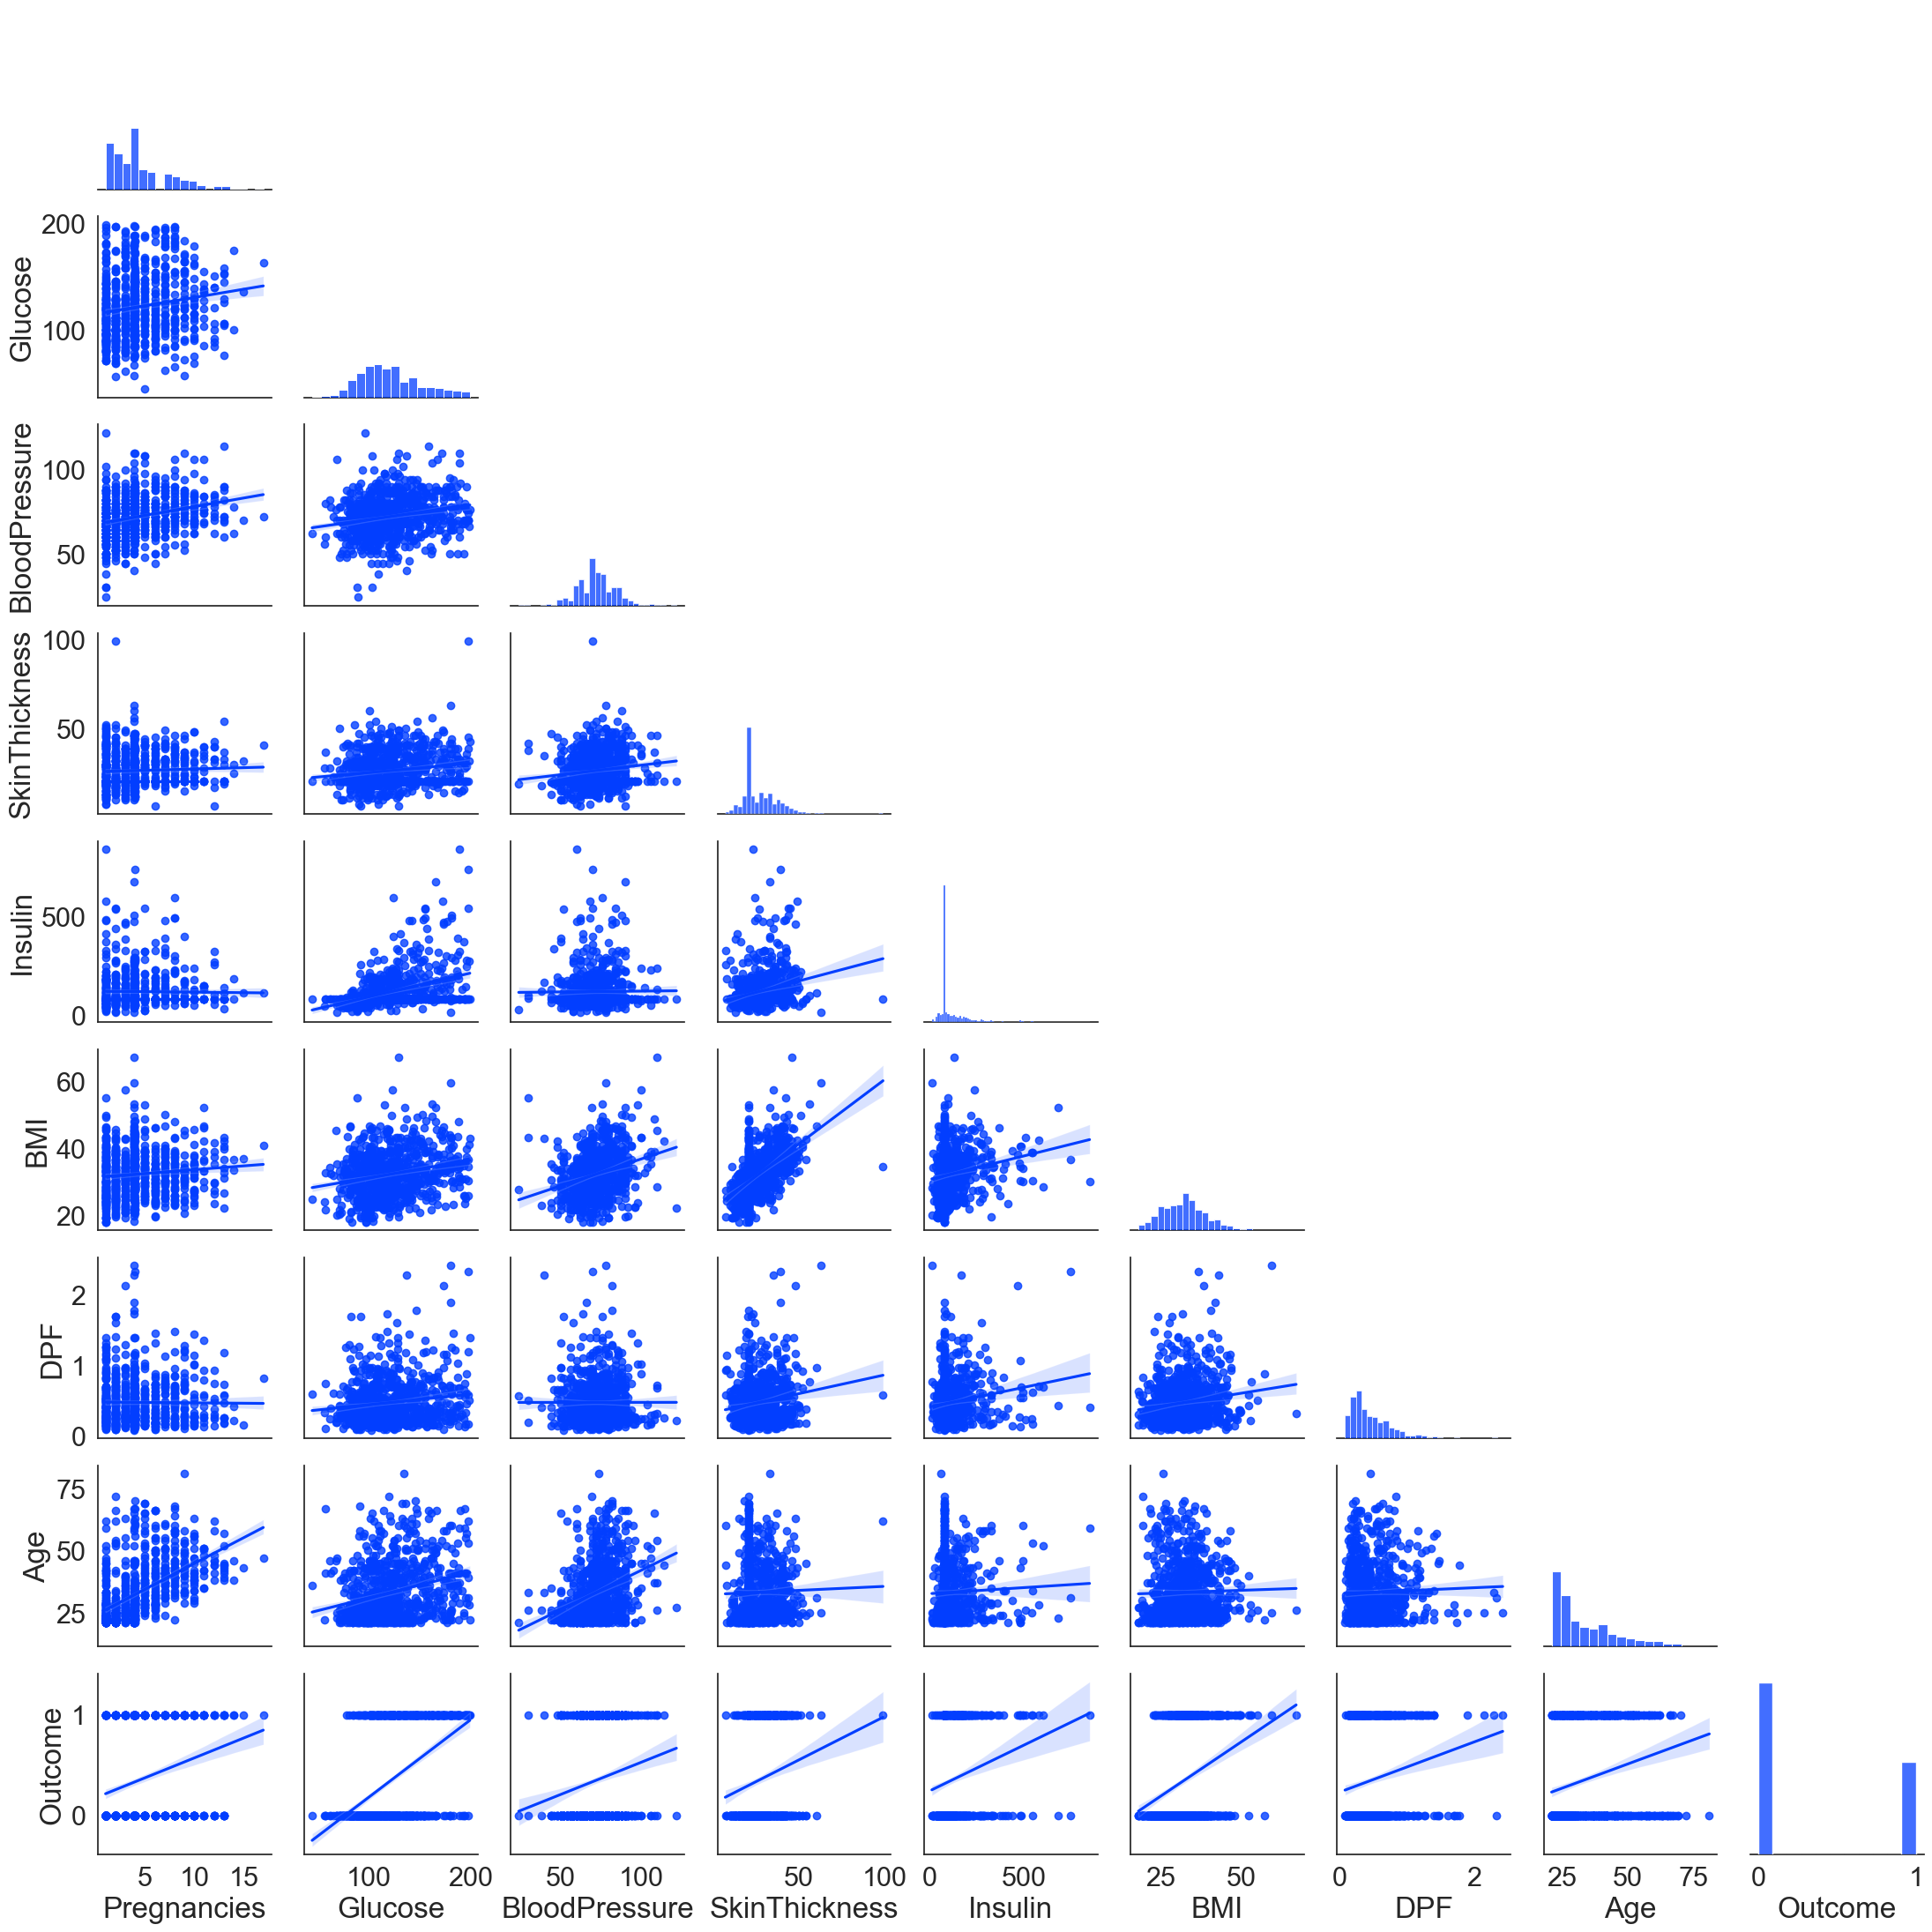

In [24]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(diabetes_df,kind = 'reg',corner = True,palette ='YlGnBu' )

-----------------------------------------------
# Checking features before modeling

In [25]:
fig = px.histogram(diabetes_df, x="Glucose", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Glucose Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [26]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="BMI", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "BMI Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [27]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="Age", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Age Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

----------------------------------------------------------------------------
# Visualizing Training Dataset after Dimension Reduction

In [28]:
X_train = diabetes_df.drop('Outcome',axis=1)
y_train = diabetes_df['Outcome']

<hr style="border: solid 3px blue;">

# Ensemble







In [29]:
from pycaret.classification import *

## Setup



In [30]:
clf1 = setup(data = diabetes_df, 
             target = 'Outcome',
             preprocess = False)

,Description,Value
0,Session id,4237
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8


In [31]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

Processing:   0%|          | 0/29 [00:00<?, ?it/s]

In [32]:
rf = create_model('rf')
lr = create_model('lr')
lda = create_model('lda')
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.8301,0.3684,0.5833,0.4516,0.2463,0.2591
1,0.7593,0.7797,0.6316,0.6667,0.6486,0.4658,0.4661
2,0.7963,0.8429,0.7368,0.7000,0.7179,0.5587,0.5591
3,0.7037,0.8481,0.5263,0.5882,0.5556,0.3344,0.3355
4,0.7778,0.8932,0.5789,0.7333,0.6471,0.4882,0.4954
5,0.7778,0.8699,0.5789,0.7333,0.6471,0.4882,0.4954
6,0.7593,0.7932,0.6316,0.6667,0.6486,0.4658,0.4661
7,0.7547,0.8754,0.5556,0.6667,0.6061,0.4301,0.4339
8,0.7170,0.7802,0.5000,0.6000,0.5455,0.3424,0.3454


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.8496,0.5789,0.7857,0.6667,0.5248,0.5375
1,0.6852,0.7429,0.5263,0.5556,0.5405,0.3014,0.3016
2,0.7963,0.8541,0.5789,0.7857,0.6667,0.5248,0.5375
3,0.7778,0.8316,0.5263,0.7692,0.6250,0.4749,0.4921
4,0.7963,0.8947,0.6316,0.7500,0.6857,0.5367,0.5410
5,0.7778,0.8812,0.6316,0.7059,0.6667,0.5008,0.5025
6,0.7407,0.7895,0.5789,0.6471,0.6111,0.4176,0.4190
7,0.7547,0.8905,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7170,0.7667,0.4444,0.6154,0.5161,0.3234,0.3320


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.8496,0.5789,0.8462,0.6875,0.5624,0.5828
1,0.6852,0.7504,0.4737,0.5625,0.5143,0.2839,0.2862
2,0.7963,0.8556,0.5789,0.7857,0.6667,0.5248,0.5375
3,0.7778,0.8331,0.5263,0.7692,0.6250,0.4749,0.4921
4,0.8148,0.8917,0.6842,0.7647,0.7222,0.5840,0.5860
5,0.7778,0.8737,0.6316,0.7059,0.6667,0.5008,0.5025
6,0.7593,0.7910,0.6316,0.6667,0.6486,0.4658,0.4661
7,0.7547,0.8873,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7170,0.7667,0.4444,0.6154,0.5161,0.3234,0.3320


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.8346,0.6316,0.7500,0.6857,0.5367,0.5410
1,0.7222,0.8030,0.5263,0.6250,0.5714,0.3682,0.3711
2,0.7222,0.8060,0.5789,0.6111,0.5946,0.3836,0.3839
3,0.7593,0.8662,0.7368,0.6364,0.6829,0.4906,0.4940
4,0.8148,0.8992,0.6842,0.7647,0.7222,0.5840,0.5860
5,0.7593,0.8692,0.5789,0.6875,0.6286,0.4524,0.4561
6,0.7407,0.7594,0.6316,0.6316,0.6316,0.4316,0.4316
7,0.7736,0.8746,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.6981,0.7365,0.5556,0.5556,0.5556,0.3270,0.3270


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

In [33]:
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8556,0.6842,0.6500,0.6667,0.4785,0.4788
1,0.6852,0.7383,0.6842,0.5417,0.6047,0.3489,0.3555
2,0.8148,0.8511,0.7368,0.7368,0.7368,0.5940,0.5940
3,0.7593,0.8526,0.7895,0.6250,0.6977,0.5021,0.5116
4,0.8333,0.9023,0.8421,0.7273,0.7805,0.6473,0.6518
5,0.7778,0.8722,0.7368,0.6667,0.7000,0.5242,0.5259
6,0.7037,0.7850,0.6842,0.5652,0.6190,0.3802,0.3848
7,0.8113,0.8873,0.7778,0.7000,0.7368,0.5904,0.5924
8,0.6792,0.7667,0.6111,0.5238,0.5641,0.3127,0.3151


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.8526,0.5263,0.8333,0.6452,0.5123,0.5389
1,0.7222,0.7459,0.4737,0.6429,0.5455,0.3520,0.3605
2,0.7963,0.8316,0.5789,0.7857,0.6667,0.5248,0.5375
3,0.7963,0.8526,0.5789,0.7857,0.6667,0.5248,0.5375
4,0.8148,0.9098,0.6842,0.7647,0.7222,0.5840,0.5860
5,0.7593,0.8662,0.5789,0.6875,0.6286,0.4524,0.4561
6,0.7593,0.7850,0.6316,0.6667,0.6486,0.4658,0.4661
7,0.7736,0.8746,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7358,0.7683,0.4444,0.6667,0.5333,0.3592,0.3736


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6481,0.8376,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6481,0.7805,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6481,0.8436,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6481,0.8632,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6481,0.8827,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6481,0.8827,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6481,0.8000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6604,0.8746,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6604,0.7921,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


-----------------------------------------------------------------------------------------------------------------------------------------
# Stacking





In [34]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:01:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8556,0.5263,0.7143,0.6061,0.4384,0.4490
1,0.7222,0.7654,0.6316,0.6000,0.6154,0.3982,0.3985
2,0.7778,0.8391,0.5789,0.7333,0.6471,0.4882,0.4954
3,0.7778,0.8767,0.5789,0.7333,0.6471,0.4882,0.4954
4,0.8148,0.9053,0.6842,0.7647,0.7222,0.5840,0.5860
5,0.7778,0.8782,0.5263,0.7692,0.6250,0.4749,0.4921
6,0.7407,0.7955,0.5789,0.6471,0.6111,0.4176,0.4190
7,0.7547,0.8857,0.5556,0.6667,0.6061,0.4301,0.4339
8,0.6981,0.7667,0.5000,0.5625,0.5294,0.3083,0.3095


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

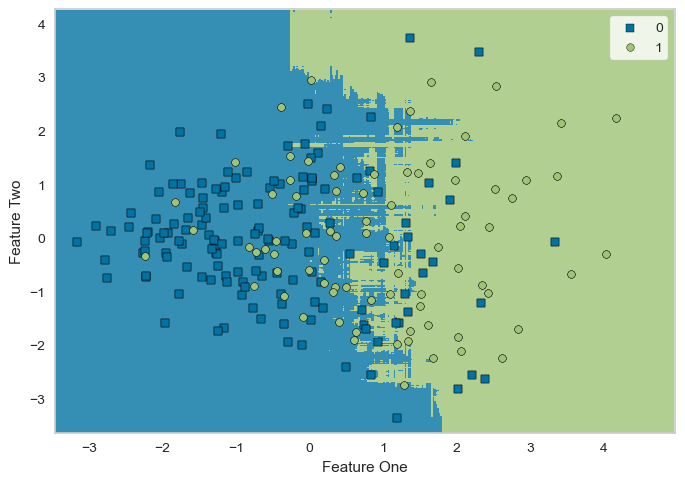

In [35]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

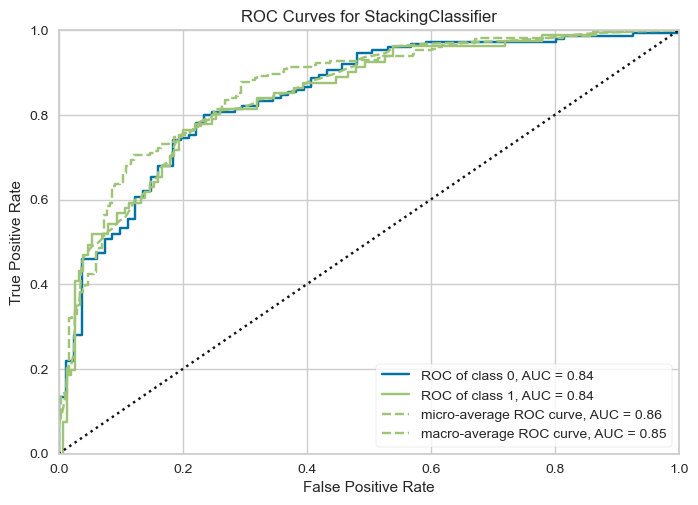

In [36]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

In [37]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8542, precision: 0.8361, recall: 0.7391,    F1: 0.7846, AUC:0.9345


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

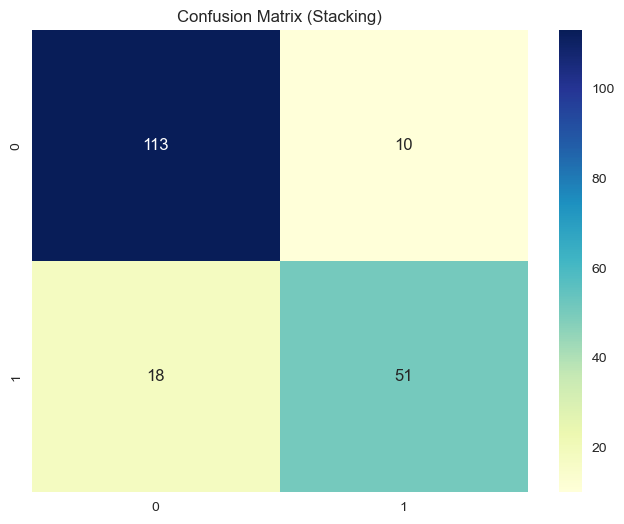

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [39]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:02:10
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8571,0.5263,0.7692,0.6250,0.4749,0.4921
1,0.7593,0.7744,0.6316,0.6667,0.6486,0.4658,0.4661
2,0.7778,0.8406,0.5789,0.7333,0.6471,0.4882,0.4954
3,0.7963,0.8797,0.6316,0.7500,0.6857,0.5367,0.5410
4,0.8148,0.9098,0.6842,0.7647,0.7222,0.5840,0.5860
5,0.7778,0.8812,0.5263,0.7692,0.6250,0.4749,0.4921
6,0.7593,0.8015,0.5789,0.6875,0.6286,0.4524,0.4561
7,0.7736,0.8889,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7170,0.7683,0.5000,0.6000,0.5455,0.3424,0.3454


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

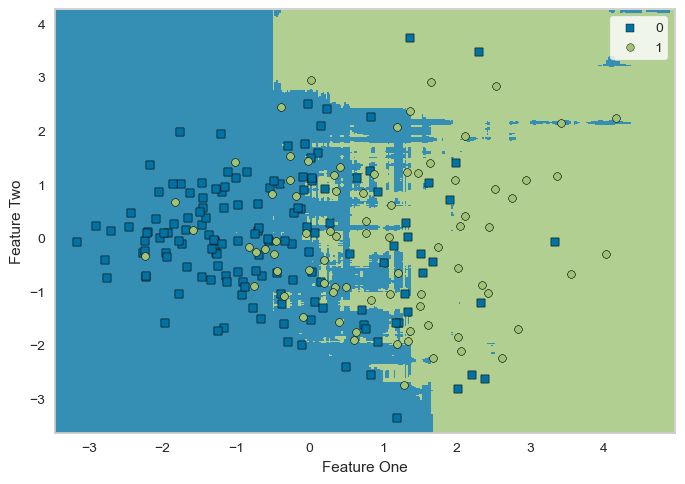

In [40]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

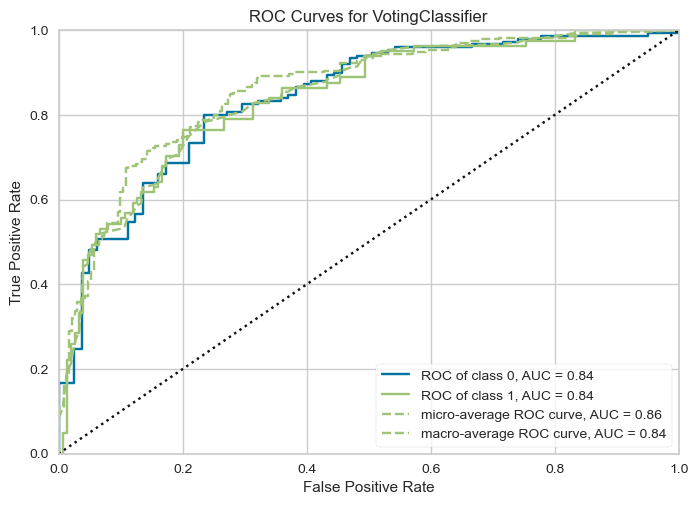

In [41]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [42]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9167, precision: 0.9206, recall: 0.8406,    F1: 0.8788, AUC:0.9573


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

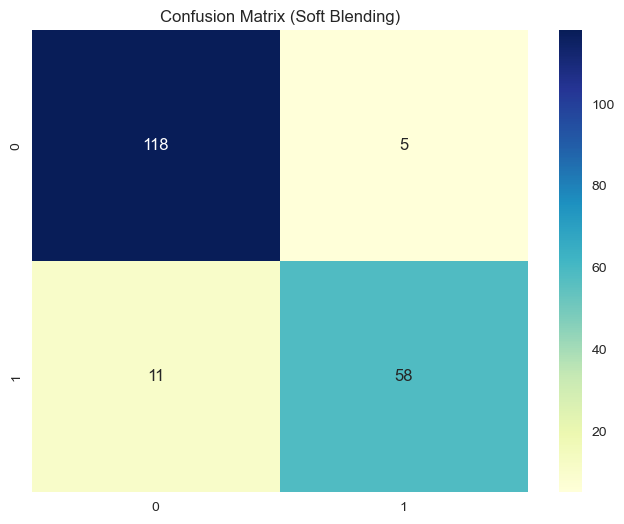

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

---------------------------------------------------------------------------------------------------------------------------------------
# Hard Voting




In [44]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

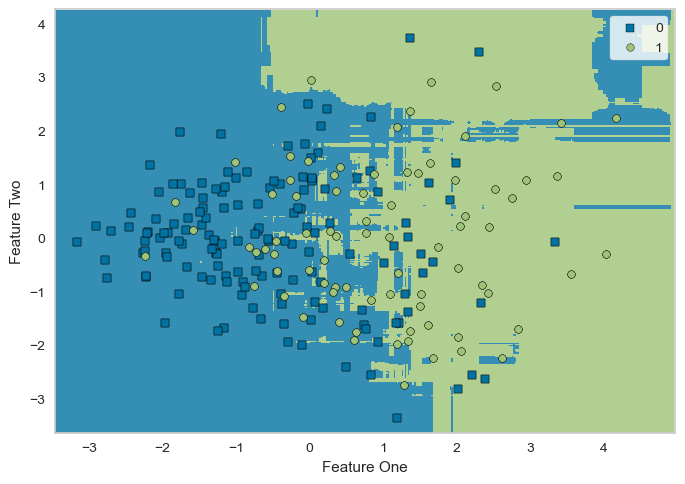

In [45]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

# Predicting with the test dateset

In [46]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9010, precision: 0.9032, recall: 0.8116,F1: 0.8550


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

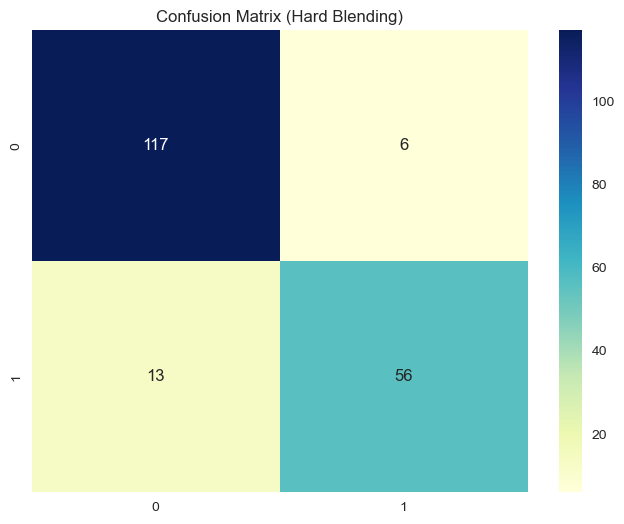

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

-----------------------------------------------
# Calibrating the final model


In [48]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8586,0.5263,0.7692,0.6250,0.4749,0.4921
1,0.7222,0.7684,0.5789,0.6111,0.5946,0.3836,0.3839
2,0.7778,0.8481,0.5789,0.7333,0.6471,0.4882,0.4954
3,0.7778,0.8707,0.5789,0.7333,0.6471,0.4882,0.4954
4,0.8148,0.9023,0.6842,0.7647,0.7222,0.5840,0.5860
5,0.7778,0.8812,0.5263,0.7692,0.6250,0.4749,0.4921
6,0.7593,0.8120,0.5789,0.6875,0.6286,0.4524,0.4561
7,0.7547,0.8889,0.5556,0.6667,0.6061,0.4301,0.4339
8,0.7358,0.7825,0.5000,0.6429,0.5625,0.3775,0.3836


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

----------------------------------------------
# Finalizing the last model



In [49]:
final_model = finalize_model(cali_model)

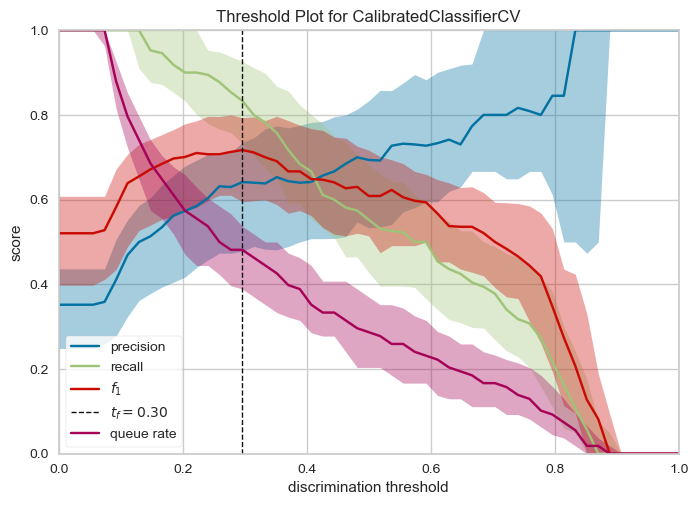

In [50]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

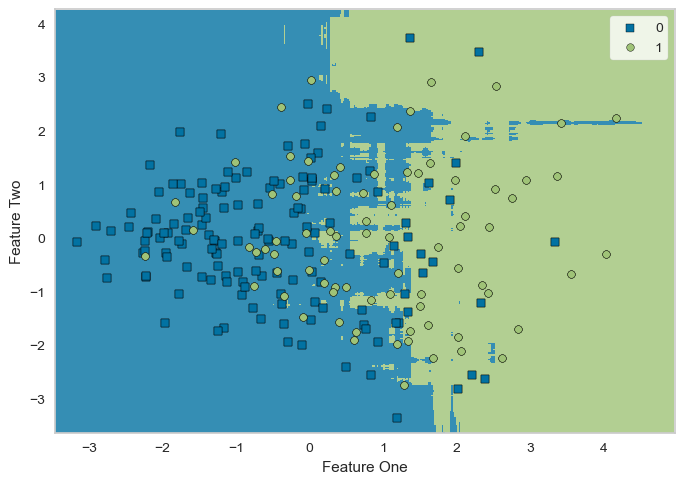

In [51]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [52]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9115, precision: 0.9194, recall: 0.8261,F1: 0.8702


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

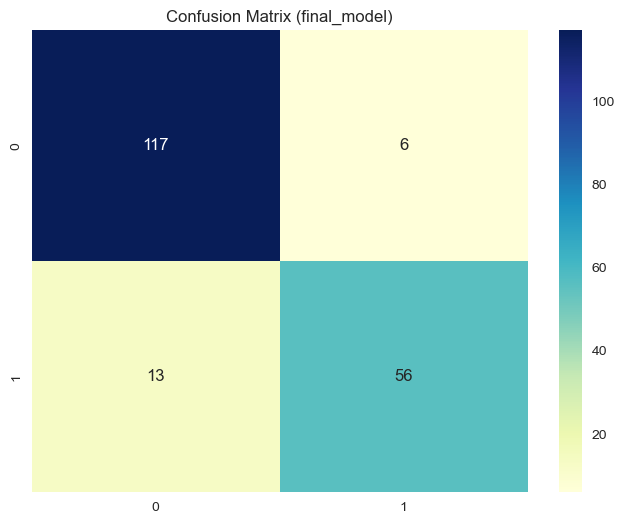

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')

<hr style="border: solid 3px blue;">

# Implementation

In [72]:
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
668,6.0,98.0,58.0,33.000000,190.000000,34.0,0.430,43
324,2.0,112.0,75.0,32.000000,79.799479,35.7,0.148,21
624,2.0,108.0,64.0,20.536458,79.799479,30.8,0.158,21
690,8.0,107.0,80.0,20.536458,79.799479,24.6,0.856,34
473,7.0,136.0,90.0,20.536458,79.799479,29.9,0.210,50
...,...,...,...,...,...,...,...,...
554,1.0,84.0,64.0,23.000000,115.000000,36.9,0.471,28
319,6.0,194.0,78.0,20.536458,79.799479,23.5,0.129,59
594,6.0,123.0,72.0,45.000000,230.000000,33.6,0.733,34
6,3.0,78.0,50.0,32.000000,88.000000,31.0,0.248,26


In [73]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int8)

In [74]:
actual_data=pd.read_excel("actual.xlsx")
actual_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
0,11,100,78,32,190,34,1.5,54
1,0,30,120,30,100,22,0.4,18
2,2,250,130,30,150,25,1.0,30


In [75]:
final_model = finalize_model(cali_model)

In [76]:
temp=final_model.predict(actual_data)
for a,b in enumerate(temp):
    if(b==0):
        print(str(a+1)+"."+"Healthy")
    else:
        print(str(a+1)+"."+"Dia")

1.Dia
2.Healthy
3.Dia
